### 1. Initial Cost Breakdown

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+
|   0    | -0.0  |   -0.0   |   80.0    |   -0.0   |  1000.0   |   0.0    |    -0.0     |    -0.0    |        |
|   1    |  0.0  |   15.0   |   65.0    |   -0.0   |  2000.0   |   -0.0   |    -0.0     |   2600.0   | 1600.0 |
|   2    |  0.0  |   0.0    |   65.0    |   -0.0   |  1600.0   |   -0.0   |     0.0     |   2600.0   | 3000.0 |
|   3    |  0.0  |   0.0    |   65.0    |   -0.0   |  1000.0   |   -0.0   |     0.0     |   2600.0   | 3200.0 |
|   4    |  0.0  |   1.0    |   64.0    |   -0.0   |   -0.0    |  220.0   |    20.0     |   2560.0   | 3800.0 |
|   5    |  0.0  |   -0.0   |   64.0    |   -0.0   |   140.0   |   -0.0   |     0.0     |   2560.0   | 2

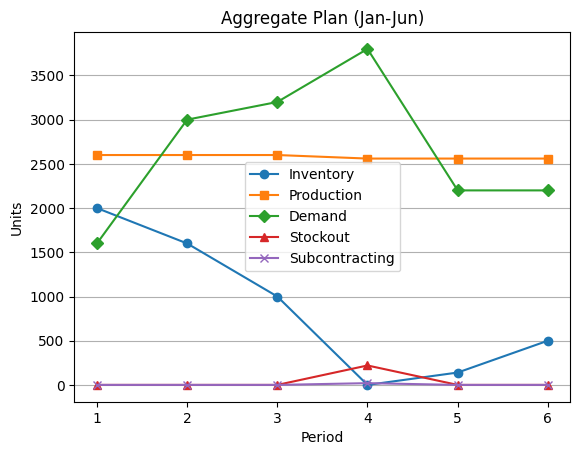

In [4]:
import numpy as np
from gurobipy import Model, GRB, quicksum
from tabulate import tabulate
import matplotlib.pyplot as plt

# --- Helper function for plotting ---
def plot_inventory(I, P, D, S, C, n_months):
    t_values = list(range(1, n_months + 1))
    plt.plot(t_values, [I[t].x for t in t_values], marker='o', label='Inventory')
    plt.plot(t_values, [P[t].x for t in t_values], marker='s', label='Production')
    plt.plot(t_values, [D[t].x for t in t_values], marker='D', label='Demand')
    plt.plot(t_values, [S[t].x for t in t_values], marker='^', label='Stockout')
    plt.plot(t_values, [C[t].x for t in t_values], marker='x', label='Subcontracting')
    plt.xlabel('Period')
    plt.ylabel('Units')
    plt.legend(loc='best')
    plt.title('Aggregate Plan (Jan-Jun)')
    plt.grid(axis='y')
    plt.show()

# --- Data and parameters ---
# Forecast for periods: 1: Jan, 2: Feb, 3: Mar, 4: Apr, 5: May, 6: Jun, (7 is extra for indexing)
F = np.array([0, 1600, 3000, 3200, 3800, 2200, 2200])
n_months = 6
# Append two zeros for use in constraints that reference F[t+1] or F[t+2]
F = np.append(F, [0, 0])

# --- Create and solve the initial optimization model ---
model = Model("MinimizeCost_Initial")

# Define decision variables for periods 0...n_months (period 0 is initial state)
H = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_{t}") for t in range(0, n_months+1)}
L = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_{t}") for t in range(0, n_months+1)}
W = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_{t}") for t in range(0, n_months+1)}
O = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_{t}") for t in range(0, n_months+1)}
I_var = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_{t}") for t in range(0, n_months+1)}
S = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_{t}") for t in range(0, n_months+1)}
C = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_{t}") for t in range(0, n_months+1)}
P = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_{t}") for t in range(0, n_months+1)}
D = {t: model.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_{t}") for t in range(0, n_months+1)}

model.update()

# Objective function:
# (Costs: Hiring=$300, Layoff=$500, Workforce cost=$640/worker, Overtime=$6/hr, 
# Inventory holding=$2/unit, Stockout=$5/unit, Subcontracting=$30/unit, Production cost=$10/unit)
model.setObjective(
    quicksum(300*H[t] + 500*L[t] + 640*W[t] + 6*O[t] + 2*I_var[t] + 5*S[t] + 30*C[t] + 10*P[t]
             for t in range(1, n_months+1)),
    GRB.MINIMIZE)

# Constraints for each period t = 1, …, 6
for t in range(1, n_months+1):
    # Workforce balance: W[t] = W[t-1] + H[t] - L[t]
    if t == 1:
        model.addConstr(W[0] == 80, name="Workforce_Initial")
    model.addConstr(W[t] - W[t-1] - H[t] + L[t] == 0, name=f"Workforce_balance_{t}")
    
    # Demand constraint (no promotion): D[t] = F[t]
    model.addConstr(D[t] == F[t], name=f"Demand_constraint_{t}")
    
    # Inventory balance: I[t-1] + P[t] + C[t] = D[t] + S[t-1] + I[t] - S[t]
    if t == 1:
        model.addConstr(I_var[0] == 1000, name="Inventory_Initial")
    model.addConstr(I_var[t-1] + P[t] + C[t] - D[t] - S[t-1] - I_var[t] + S[t] == 0, name=f"Inventory_balance_{t}")
    
    # End-of-horizon constraints (apply at period 6)
    if t == n_months:
        model.addConstr(I_var[t] >= 500, name="Inventory_End")
        model.addConstr(S[t] == 0, name="Stockout_End")
    
    # Production capacity: P[t] ≤ 40×W[t] + O[t]/4
    model.addConstr(40*W[t] + O[t]/4 - P[t] >= 0, name=f"Production_capacity_{t}")
    
    # Overtime limit: O[t] ≤ 10×W[t]
    model.addConstr(10*W[t] - O[t] >= 0, name=f"Overtime_limit_{t}")

model.Params.OutputFlag = 0  # Suppress solver output
model.optimize()

# Print results in a table
opt_results = []
for t in range(0, n_months+1):
    opt_results.append([
        t,
        H[t].x,
        L[t].x,
        W[t].x,
        O[t].x,
        I_var[t].x,
        S[t].x,
        C[t].x,
        P[t].x,
        D[t].x if t > 0 else None  # No demand for period 0
    ])

headers = ["Period", "Hired", "Laid Off", "Workforce", "Overtime", "Inventory", "Stockout", "Subcontract", "Production", "Demand"]
print(tabulate(opt_results, headers=headers, tablefmt="pretty"))
print(f"Minimum Cost : $ {model.objVal:,.2f}")

# Plot the initial plan trends
plot_inventory(I_var, P, D, S, C, n_months)


### 2. January Update: Demand Realization and Cost Impact

In [3]:
# Retrieve planned January production from the model solution:
P_Jan = P[1].x
I0 = 1000
planned_Jan_demand = 1600
actual_Jan_demand  = 1400

# Compute ending inventory for January as planned and as realized:
I_Jan_planned = I0 + P_Jan - planned_Jan_demand
I_Jan_actual  = I0 + P_Jan - actual_Jan_demand

extra_inventory = I_Jan_actual - I_Jan_planned
holding_cost_per_unit = 2  # $2/unit per month
additional_cost = extra_inventory * holding_cost_per_unit

print(f"Planned January Ending Inventory: {I_Jan_planned}")
print(f"Actual January Ending Inventory:  {I_Jan_actual}")
print(f"Extra Inventory (units):          {extra_inventory}")
print(f"Additional Holding Cost in January: $ {additional_cost:.2f}")

Planned January Ending Inventory: 2000.0
Actual January Ending Inventory:  2200.0
Extra Inventory (units):          200.0
Additional Holding Cost in January: $ 400.00


### 3. Updated S&OP Forecasts for February–July

In [12]:
# New forecast array: index 1: Feb, 2: Mar, 3: Apr, 4: May, 5: Jun, 6: Jul
F_updated = np.array([0, 3000, 3200, 3900, 2200, 2200, 1200])
n_months_new = 6
F_updated = np.append(F_updated, [0, 0])  # Append extra zeros for indexing

# New initial conditions taken from the January update:
I_initial_new = I_Jan_actual  # Updated inventory from January
W_initial_new = W[1].x        # Workforce level from January (from the initial plan)

# --- Build the updated optimization model for periods Feb-Jul ---
model_new = Model("MinimizeCost_Updated")

H_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"H_new_{t}") for t in range(0, n_months_new+1)}
L_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"L_new_{t}") for t in range(0, n_months_new+1)}
W_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"W_new_{t}") for t in range(0, n_months_new+1)}
O_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"O_new_{t}") for t in range(0, n_months_new+1)}
I_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"I_new_{t}") for t in range(0, n_months_new+1)}
S_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"S_new_{t}") for t in range(0, n_months_new+1)}
C_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"C_new_{t}") for t in range(0, n_months_new+1)}
P_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"P_new_{t}") for t in range(0, n_months_new+1)}
D_new = {t: model_new.addVar(vtype=GRB.INTEGER, lb=0, name=f"D_new_{t}") for t in range(0, n_months_new+1)}

model_new.update()

# Objective function remains the same as before:
model_new.setObjective(
    quicksum(300*H_new[t] + 500*L_new[t] + 640*W_new[t] + 6*O_new[t] + 2*I_new[t] + 5*S_new[t] + 30*C_new[t] + 10*P_new[t]
             for t in range(1, n_months_new+1)),
    GRB.MINIMIZE)

for t in range(1, n_months_new+1):
    # Workforce balance
    if t == 1:
        model_new.addConstr(W_new[0] == W_initial_new, name="Workforce_Initial_new")
        model_new.addConstr(I_new[0] == I_initial_new, name="Inventory_Initial_new")
    model_new.addConstr(W_new[t] - W_new[t-1] - H_new[t] + L_new[t] == 0, name=f"Workforce_balance_new_{t}")
    
    # Demand constraint with updated forecast:
    model_new.addConstr(D_new[t] == F_updated[t], name=f"Demand_constraint_new_{t}")
    
    # Inventory balance: I[t-1] + P[t] + C[t] = D[t] + S[t-1] + I[t] - S[t]
    model_new.addConstr(I_new[t-1] + P_new[t] + C_new[t] - D_new[t] - S_new[t-1] - I_new[t] + S_new[t] == 0,
                          name=f"Inventory_balance_new_{t}")
    
    # End-of-horizon constraints for period 6 (July)
    if t == n_months_new:
        model_new.addConstr(I_new[t] >= 500, name="Inventory_End_new")
        model_new.addConstr(S_new[t] == 0, name="Stockout_End_new")
    
    # Production capacity: P[t] ≤ 40×W[t] + O[t]/4
    model_new.addConstr(40*W_new[t] + O_new[t]/4 - P_new[t] >= 0, name=f"Production_capacity_new_{t}")
    
    # Overtime limit: O[t] ≤ 10×W[t]
    model_new.addConstr(10*W_new[t] - O_new[t] >= 0, name=f"Overtime_limit_new_{t}")

model_new.Params.OutputFlag = 0
model_new.optimize()

# Print updated plan results:
opt_results_new = []
for t in range(0, n_months_new+1):
    opt_results_new.append([
        t,
        H_new[t].x,
        L_new[t].x,
        W_new[t].x,
        O_new[t].x,
        I_new[t].x,
        S_new[t].x,
        C_new[t].x,
        P_new[t].x,
        D_new[t].x if t > 0 else None
    ])

print(tabulate(opt_results_new, headers=headers, tablefmt="pretty"))
print(f"Updated Minimum Cost : $ {model_new.objVal:,.2f}")

+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+
| Period | Hired | Laid Off | Workforce | Overtime | Inventory | Stockout | Subcontract | Production | Demand |
+--------+-------+----------+-----------+----------+-----------+----------+-------------+------------+--------+
|   0    | -0.0  |   -0.0   |   65.0    |   -0.0   |  2200.0   |   0.0    |    -0.0     |    -0.0    |        |
|   1    |  0.0  |   -0.0   |   65.0    |   -0.0   |  1800.0   |   -0.0   |    -0.0     |   2600.0   | 3000.0 |
|   2    |  0.0  |   -0.0   |   65.0    |   -0.0   |  1200.0   |   -0.0   |     0.0     |   2600.0   | 3200.0 |
|   3    |  0.0  |   -0.0   |   65.0    |   -0.0   |   -0.0    |   20.0   |    80.0     |   2600.0   | 3900.0 |
|   4    |  0.0  |   10.0   |   55.0    |   -0.0   |   -0.0    |   20.0   |     0.0     |   2200.0   | 2200.0 |
|   5    |  0.0  |   6.0    |   49.0    |   -0.0   |   -0.0    |  260.0   |     0.0     |   1960.0   | 2

### 4. Updated Cost Difference

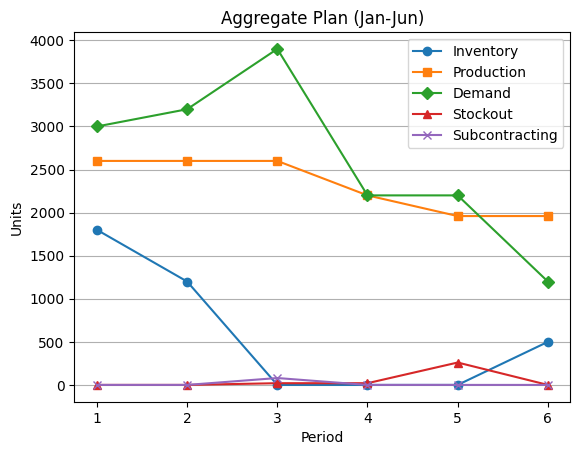

Original Cost (Feb-Jun): $ 343,560.00
Updated Cost (Feb-Jun):  $ 328,860.00
Cost Difference:         $ -14,700.00


In [10]:
# --- Cost Calculation for Original Plan (Feb-Jun) ---
# Compute January cost from the initial model:
cost_Jan = (300 * H[1].x + 500 * L[1].x + 640 * W[1].x + 6 * O[1].x +
            2 * I_var[1].x + 5 * S[1].x + 30 * C[1].x + 10 * P[1].x)
cost_Feb_Jun_original = model.objVal - cost_Jan

# --- Cost Calculation for Updated Plan (Feb-Jun) ---
# In the updated plan, periods 1 to 5 correspond to Feb–Jun.
cost_Feb_Jun_updated = sum(300 * H_new[t].x + 500 * L_new[t].x + 640 * W_new[t].x + 6 * O_new[t].x +
                           2 * I_new[t].x + 5 * S_new[t].x + 30 * C_new[t].x + 10 * P_new[t].x
                           for t in range(1, n_months_new))  # t=1..5

cost_difference = cost_Feb_Jun_updated - cost_Feb_Jun_original

plot_inventory(I_new, P_new, D_new, S_new, C_new, n_months_new)

print(f"Original Cost (Feb-Jun): $ {cost_Feb_Jun_original:,.2f}")
print(f"Updated Cost (Feb-Jun):  $ {cost_Feb_Jun_updated:,.2f}")
print(f"Cost Difference:         $ {cost_difference:,.2f}")
